In [10]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from numpy import linalg
#from scipy import optimize
import blackbox as bb
import matplotlib as mpl

In [11]:
plotting_on = 1
mask_plotting = 1
cluster_size = 2
noise_threshold = 10.0
#S = 20
S = 1

#sample_size = 5000
#sample_size = 1200
#sample_size = 50
#sample_size = 200
#sample_size = 50
sample_size = 49
cluster_size = 2

spill_over = False
spill_over_idx = []

In [12]:
def plot_clusters(X, labels):
    chosen_pts_cluster_label = []
    for idx, label in enumerate(labels):
        if label == 0:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'lawngreen',s = 30)

        if label == 1:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'red', s = 30)

        if mask[idx] == 1:
            chosen_pts_cluster_label.append(label)
            if plotting_on and mask_plotting:
                plt.scatter(X[idx,0], X[idx,1], color = 'blue', s = 30)#, edgecolors='black')
                #plt.scatter(X[idx,0], X[idx,1], color = 'lawngreen', s = 30, edgecolors='black')
                #plt.scatter(X[idx,0], X[idx,1], color = 'lawngreen', s = 30, edgecolors='black')
                #plt.scatter(X[idx,0], X[idx,1], color = 'lawngreen', s = 30, edgecolors='black')
                #plt.scatter(X[idx,0], X[idx,1], color = 'lawngreen', s = 30, edgecolors='black')
                #plt.scatter(X[idx,0], X[idx,1], color = 'lawngreen', s = 30, edgecolors='black')
                
        if spill_over:
            if plotting_on:
                for i in spill_over_idx:
                    plt.scatter(X[i,0], X[i,1], color = 'darkorange', s=30)
    
    #Simplical Liu depth contours obtained using R package
    x = np.genfromtxt('x.csv', delimiter=',') 
    y = np.genfromtxt('y.csv', delimiter=',')
    #z = np.genfromtxt('z.csv', delimiter=',')
    z = np.genfromtxt('z_approx.csv', delimiter=',')
    cmap = mpl.cm.PuBu(np.linspace(0,1,40))
    cmap = mpl.colors.ListedColormap(cmap[10:,:-1])


    plt.contour(x,y,z.T, cmap = cmap, linestyle = 'dotted', linewidth=0.5)
    if plotting_on:
        plt.show()
    return chosen_pts_cluster_label

def get_Y(labels,n_samples, n_clusters):
    Y = np.zeros([n_samples, n_clusters])
    for idx, label in enumerate(labels):
        Y[idx, label] = 1
    return Y

def run_kmeans(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
def add_noise(X,noise):
    for i,(m,_) in enumerate(zip(mask,X)):
        if m != 0:
            X[i,:] = X[i,:] + noise
    return X

def get_dist(Y,Y_dash):
    dist = linalg.norm(np.matmul(Y,Y.T) - np.matmul(Y_dash,Y_dash.T))
    return dist

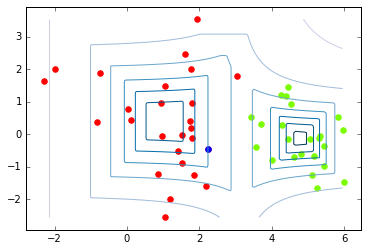

[1]

In [13]:
data = datasets.make_blobs(n_samples=sample_size, cluster_std=[1.45,0.75], random_state=170, centers = [[1,0],[5,0]])
X = data[0]
y = data[1]

np.savetxt('data.csv', X, delimiter=',')

mask = np.zeros((sample_size))
n_features = X.shape[1]

X_org = np.copy(X)

kmeans_d = KMeans(n_clusters = cluster_size, random_state=42)
labels_d = kmeans_d.fit_predict(X)    
centers_d = kmeans_d.cluster_centers_

temp_d = np.copy(labels_d)
temp_c_d = np.copy(centers_d)
if np.sum(centers_d[0,:]) < np.sum(centers_d[1,:]):
    labels_d[temp_d == 0] = 1
    labels_d[temp_d == 1] = 0
    centers_d[1,:] = temp_c_d[0,:]
    centers_d[0,:] = temp_c_d[1,:]

best_vals = []
for idx,label in enumerate(labels_d):
    if label == 1:
        best_vals.append(linalg.norm(X[idx,:] - centers_d[0,:]))
    else:
        best_vals.append(1000000)

best_vals = np.array(best_vals)
best_vals_idx = np.argsort(best_vals)

count = 0
mask_idx = -1
for idx in range(0,sample_size):
    if idx in best_vals_idx[:S]:
        mask[idx] = 1
        count+=1
        mask_idx = idx

plot_clusters(X, labels_d)

#np.savetxt('blue_cluster.csv',X[labels_d == 0], delimiter=',')
#np.savetxt('red_cluster.csv',X[labels_d == 1], delimiter=',')

In [14]:
print(labels_d[mask_idx])
dist_center0 = 0
dist_center1 = 0
cluster0_size = 0
cluster1_size = 0
for i,x in enumerate(X):
    if mask[i] == 1:
        dist_center0 += linalg.norm(X[mask_idx] - centers_d[0,:]) 
        dist_center1 += linalg.norm(X[mask_idx] - centers_d[1,:])
    if labels_d[i] == 0:
        cluster0_size += 1
    if labels_d[i] == 1:
        cluster1_size += 1
print(dist_center0)
print(dist_center1)
print(cluster0_size, cluster1_size)

1
2.5856210661994714
1.4843602320603244
(23, 26)


In [15]:
print(np.inner((X[mask_idx] - centers_d[1,:]), centers_d[0,:] - centers_d[1,:]))

5.0510795646096


In [16]:
def f(x):
    success = 0.0
    noise = np.array(x)
    (labels, centers) = run_kmeans(cluster_size, X_org)
    org_label = labels[mask_idx]
    Y = get_Y(labels, sample_size, cluster_size)
    X_noisy = np.copy(X_org)
    X_noisy  = add_noise(X_noisy, noise)
    (labels_dash, centers_dash) = run_kmeans(cluster_size, X_noisy)
    noisy_label = labels_dash[mask_idx]
    Y_dash = get_Y(labels_dash, sample_size, cluster_size)  
    dist = get_dist(Y,Y_dash)
    
    if dist != 0.0:
        return -dist
    else:
        return 1000000.0

In [62]:
bb.search(f=f,  # given function
          box=[[0, 3.5], [-3.5, 3.5]],  # range of values for each parameter (2D case)
          n=50,  # number of function calls on initial stage (global search)
          m=50,  # number of function calls on subsequent stage (local search)
          batch=4,  # number of calls that will be evaluated in parallel
          resfile='output.csv')  # text file where results will be saved

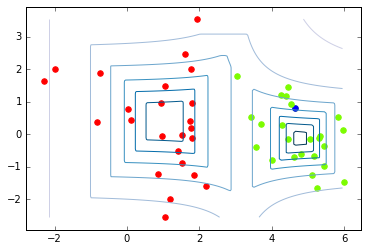

[0]

In [17]:
spill_over_idx = []
best_noise = np.array([+2.4062e+00, +1.2558e+00])
X_adv = np.copy(X_org)
X_adv = add_noise(X_adv, best_noise)


Xo = np.copy(X_org)
Xa = np.copy(X_adv)

lo,_ = run_kmeans(2, Xo)
la,_ = run_kmeans(2, Xa)

plot_clusters(Xa, la)
#np.savetxt('adv_blue_cluster.csv',Xa[la == 0], delimiter=',')
#np.savetxt('adv_red_cluster.csv',Xa[la == 1], delimiter=',')

(1, 0)
2


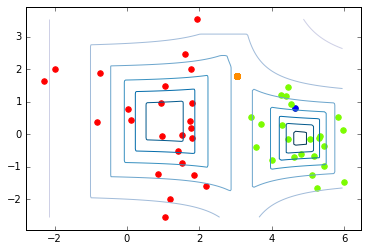

[0]

In [18]:
print(lo[mask_idx],la[mask_idx])
count_diffs = 0
perturbed_idx = []

for idx,(el1, el2) in enumerate(zip(lo,la)):
    if el1 != el2:
        count_diffs += 1
        perturbed_idx.append(idx)
        if mask[idx] != 1:
            spill_over = True
            spill_over_idx.append(idx)
print(count_diffs)

plot_clusters(Xa, la)

In [119]:
for idx in spill_over_idx:
    print(np.inner((X[mask_idx] - centers_d[1,:]),(X[idx] - centers_d[1,:])))

1.2872045626984219
